In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap

import jaxley as jx
# from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect

In [2]:
cell = jx.read_swc("morphology/Park_2019.swc", ncomp=1, assign_groups=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<Axes: >

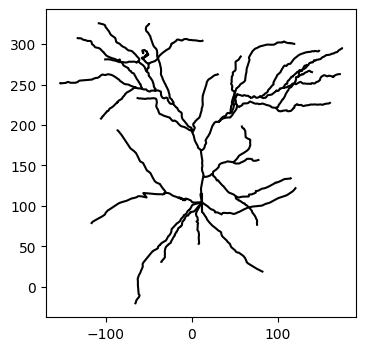

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)
cell.branch(0).vis(ax=ax, color="r")
cell.branch(0).loc(0.5).vis(ax=ax, color="b")

In [4]:
cell.set("axial_resistivity", 100)
cell.branch(0).set('radius', 10)
cell.branch(0).set('length', 20)
cell.set('capacitance', 2)
cell.branch(0).set('capacitance', 1)
cell.set('v', -79)

In [5]:
from jaxley.channels import Channel
from jaxley.solver_gate import exponential_euler
import jax.numpy as jnp

class Leak(Channel):
    """Leakage current"""

    def __init__(self, name = None):
        self.current_is_in_mA_per_cm2=True
        super().__init__(name)
        prefix = self._name
        self.channel_params = {
            f"{prefix}_g": 0,  # S/cm^2
            f"{prefix}_e": -79.0,  # mV
        }
        self.channel_states = {}
        self.current_name = f"i_Leak"

    def update_states(
        self, states, dt, v, params
    ):
        """No state to update."""
        return {}

    def compute_current(
        self, states, v, params
    ):
        """Return current."""
        # Multiply with 1000 to convert Siemens to milli Siemens.
        prefix = self._name
        leak_conds = params[f"{prefix}_g"] # mS/cm^2
        return leak_conds * (v - params[f"{prefix}_e"])

    def init_state(self, states, v, params, delta_t):
        """Initialize the state such at fixed point of gate dynamics."""
        return {}

In [6]:
# Insert channels.
cell.insert(Leak())
cell.set('Leak_g', 0.000091)

In [7]:
import time
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"  Elapsed time: {round(end-start, 2)} seconds")
        return result
    return wrapper

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
  Elapsed time: 2.07 seconds
  Elapsed time: 0.02 seconds


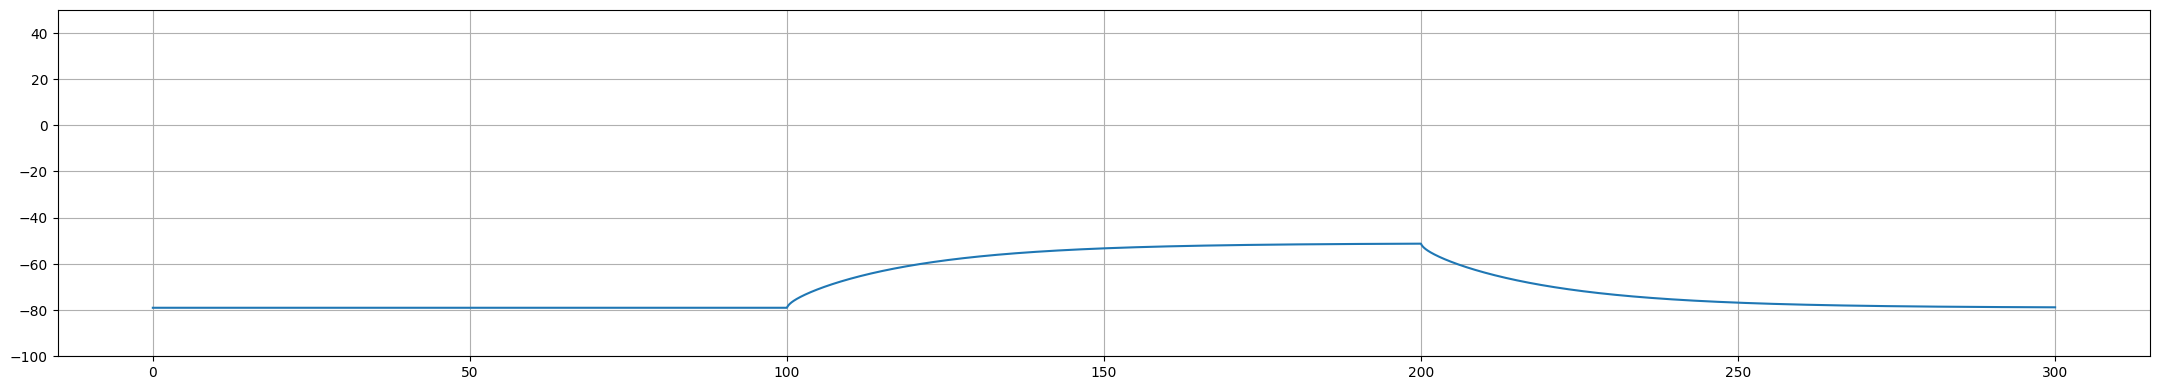

In [8]:
# Stimulate.
cell.delete_stimuli()
current = jx.step_current(i_delay=100.0, i_dur=100.0, i_amp=0.25, delta_t=0.025, t_max=300.0)
cell.branch(0).loc(0.5).stimulate(current)

# Record.
cell.delete_recordings()
cell.branch(0).loc(0.5).record("v")

# Simulate and plot.
@timeit
def simulate():
    dt = 0.025
    t_max = 300.0
    time_vec = np.arange(0, t_max+2*dt, dt)
    v = jx.integrate(cell, voltage_solver='jax.sparse').block_until_ready()
    return time_vec, v

time_vec, v = simulate()

@timeit
def plot_results(time_vec, v):
    fig, ax = plt.subplots(1, 1, figsize=(27, 4.5))
    plt.plot(time_vec, jnp.squeeze(v))
    plt.ylim(-100, 50)
    plt.grid()

plot_results(time_vec, v)